# PBO against LQR

## Define paramters

In [1]:
%load_ext autoreload
%autoreload 2

import jax

# keys
seed = 0
key = jax.random.PRNGKey(seed)
env_key, key = jax.random.split(key)
greedy_key, key = jax.random.split(key)
shuffle_key, key = jax.random.split(key)
q_network_key, key = jax.random.split(key)
random_weights_key, key = jax.random.split(key)
pbo_network_key, key = jax.random.split(key)
training_q_key, key = jax.random.split(key)

# Box over states and actions
max_discrete_state = 7
n_discrete_states = 5
max_discrete_action = 9
n_discrete_actions = 7

gamma = 1

# Sample collection
n_samples = 1000
epsilon_greedy = 0.3
max_episode_length = 4

# Q function
layer_dimension = 50
random_weights_range = 1
action_range_on_max = 2 * max_discrete_action
n_actions_on_max = 1000

# Q trainings
max_iterations = 10000
batch_size_q = 1
learning_rate_q = 0.001

# PBO trainings
n_iterations = 10000
batch_size_pbo = 1
learning_rate_pbo = 0.0001

# Visualisation
plot_freq = 200
sleeping_time = 0

## Define environment

In [2]:
import numpy as np

from pbo.environment.linear_quadratic import LinearQuadraticEnv


discrete_states = np.linspace(-max_discrete_state, max_discrete_state, n_discrete_states)
state_box_half_size = max_discrete_state / n_discrete_states
discrete_states_boxes = np.linspace(
    -max_discrete_state - state_box_half_size, max_discrete_state + state_box_half_size, n_discrete_states + 1
)

discrete_actions = np.linspace(-max_discrete_action, max_discrete_action, n_discrete_actions)
action_box_half_size = max_discrete_action / n_discrete_actions
discrete_actions_boxes = np.linspace(
    -max_discrete_action - action_box_half_size, max_discrete_action + action_box_half_size, n_discrete_actions + 1
)

env = LinearQuadraticEnv(env_key, max_init_state=max_discrete_state)

Transition: s' = As + Ba
Transition: s' = -0.4399999976158142s + 0.3700000047683716a
Reward: Qs² + Ra² + 2 Ssa
Reward: -0.4099999964237213s² + -0.47999998927116394a² + 0.8199999928474426sa


## Collect samples

### Epsilon greedy from optimal actions

In [3]:
from pbo.data_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

state = env.reset()
idx_sample = 0
epidose_length = 0

while idx_sample < n_samples:
    greedy_key, key = jax.random.split(greedy_key)
    if jax.random.uniform(key) < epsilon_greedy:
       action = env.optimal_action()
    else:
        greedy_key, key = jax.random.split(greedy_key)
        action = jax.random.uniform(key, [env.B.shape[0]], minval=discrete_actions[0], maxval=discrete_actions[-1])
    next_state, reward, _, _ = env.step(action)

    replay_buffer.add(state, action, reward, next_state)

    epidose_length += 1
    idx_sample += 1

    if epidose_length >= max_episode_length:
        state = env.reset()
        epidose_length = 0
    else:    
        state = next_state

### Samples on the crosses of the box

In [4]:
import jax.numpy as jnp

from pbo.data_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

state = env.reset()
idx_sample = 0
epidose_length = 0

for state in discrete_states:
    for action in discrete_actions:
        env.reset(jnp.array([state]))
        next_state, reward, _, _ = env.step(jnp.array([action]))

        replay_buffer.add(jnp.array([state]), jnp.array([action]), reward, next_state)

## Visualize samples

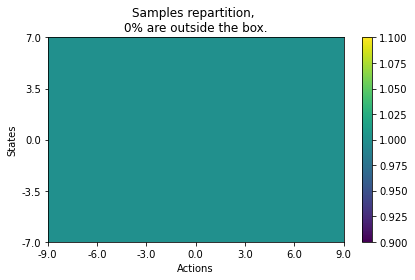

In [5]:
from pbo.data_collection.count_samples import count_samples
from pbo.utils.state_action_mesh import StateActionMesh


samples_count, n_outside_boxes = count_samples(replay_buffer, discrete_states_boxes, discrete_actions_boxes)
samples_visualization_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time=0)

samples_visualization_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visualization_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box."
)


## Optimal Q function

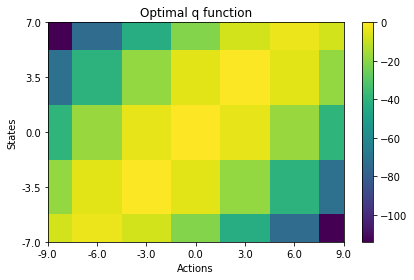

In [11]:
import pandas as pd
from pbo.utils.compute_Q_lqr import compute_Q_lqr


optimal_q = compute_Q_lqr(env, discrete_states, discrete_actions, gamma)
optimal_q_pd = pd.DataFrame(optimal_q, index=discrete_states, columns=discrete_actions)

q_funcions_visualization_mesh = StateActionMesh(discrete_states, discrete_actions, sleeping_time)

q_funcions_visualization_mesh.set_values(optimal_q)
q_funcions_visualization_mesh.show("Optimal q function")

## Build q network and its dataloader

In [12]:
from pbo.networks.jax.q import FullyConnectedQFunction
from pbo.data_collection.dataloader import DataLoader


q_function = FullyConnectedQFunction(
    layer_dimension=layer_dimension,
    network_key=q_network_key,
    random_weights_range=random_weights_range,
    random_weights_key=random_weights_key,
    action_range_on_max=action_range_on_max,
    n_actions_on_max=n_actions_on_max,
)

replay_buffer.cast_to_jax_array()
data_loader_q = DataLoader(replay_buffer, batch_size_q, shuffle_key)

## Train Q 
Objective: See if the representation power of the network of Q is powerful enough to represent the optimal Q

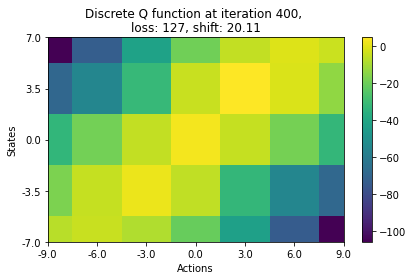

KeyboardInterrupt: 

In [13]:
import optax
import jax.numpy as jnp


optimizer = optax.sgd(learning_rate=learning_rate_q)
optimizer_state = optimizer.init(q_function.params)

# For visualization
previous_discrete_q_network = q_function.get_discrete_q(q_function.params, discrete_states, discrete_actions)
cumulative_losses = []
shifts = []

iteration = 0
cumulative_loss = float("inf")

while cumulative_loss > np.prod(optimal_q.shape) and iteration < max_iterations:
    cumulative_loss = 0

    data_loader_q.shuffle()
    for batch in data_loader_q:
        target = jnp.diag(optimal_q_pd.loc[batch["state"].flatten(), batch["action"].flatten()].values).reshape(-1, 1)

        loss, grad_loss = q_function.l1_loss_and_grad_loss(q_function.params, batch["state"], batch["action"], target)
        updates, optimizer_state = optimizer.update(
            grad_loss, optimizer_state
        )
        q_function.params = optax.apply_updates(q_function.params, updates)

        cumulative_loss += loss

    iteration += 1

    # Plot Q network
    if iteration % plot_freq == 0:
        discrete_q_network = q_function.get_discrete_q(q_function.params, discrete_states, discrete_actions)
        shift = np.linalg.norm(discrete_q_network - previous_discrete_q_network)
        
        q_funcions_visualization_mesh.set_values(discrete_q_network)
        q_funcions_visualization_mesh.show(f"Discrete Q function at iteration {iteration}, \nloss: {int(cumulative_loss)}, shift: {np.around(shift, 2)}")
        
        cumulative_losses.append(cumulative_loss)
        shifts.append(shift)
        previous_discrete_q_network = discrete_q_network

good_q_params = q_function.params

discrete_q_network = q_function.get_discrete_q(q_function.params, discrete_states, discrete_actions)
q_funcions_visualization_mesh.set_values(discrete_q_network - optimal_q)
q_funcions_visualization_mesh.show(f"Difference between optimal Q function and the neural network Q at iteration {iteration}, \n final loss: {int(cumulative_loss)}")

# Plot the shifts and the loss
fig, ax1 = plt.subplots()

ax1.set_xlabel(f"every {plot_freq} iteration")
ax1.set_ylabel("cumulative loss", color="blue")
ax1.plot(np.arange(len(cumulative_losses)), cumulative_losses, color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("shift", color="red")
ax2.plot(np.arange(len(shifts)), shifts, color="red")
ax2.tick_params(axis="y", labelcolor="red")

fig.tight_layout()
plt.show()

## Maximizing Q over actions

- Q is not spiky so discretizing the action space should work
- Taking random init weights gives smaller maximums than taking random weights

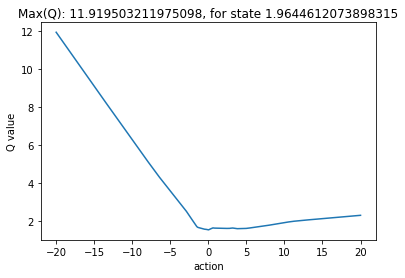

In [14]:
import matplotlib.pyplot as plt


# random_q_params = q_function.convert_to_params(q_function.get_random_weights())
random_q_params = q_function.convert_to_params(q_function.get_random_init_weights())
state = jnp.array([np.random.uniform(-max_discrete_state, max_discrete_state)])

discrete_actions_on_max = jnp.linspace(
    -20, 20, num=10000
).reshape((-1, 1))

q_values = q_function.network.apply(
    random_q_params, state.repeat(len(discrete_actions_on_max)).reshape((-1, 1)), discrete_actions_on_max
)

plt.plot(discrete_actions_on_max, q_values)
plt.xlabel("action")
plt.ylabel("Q value")
_ = plt.title(f"Max(Q): {q_values.max()}, for state {state[0]}")

## Build PBO network and its dataloader

In [40]:
from pbo.networks.jax.pbo import LinearPBOFunction


pbo_function = LinearPBOFunction(pbo_network_key, gamma, q_function)

data_loader_pbo = DataLoader(replay_buffer, batch_size_pbo, shuffle_key)

## Train PBO on one iteration over one random init weight

### Starting from random init weiths

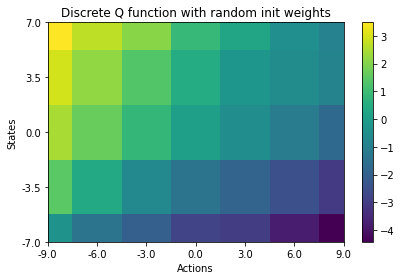

In [26]:
random_init_q_weights = q_function.get_random_init_weights()
random_init_q_params = q_function.convert_to_params(random_init_q_weights)

discrete_q_from_random = q_function.get_discrete_q(random_init_q_params, discrete_states, discrete_actions)
q_funcions_visualization_mesh.set_values(discrete_q_from_random)
q_funcions_visualization_mesh.show(f"Discrete Q function with random init weights")

### Iterating over the Q function with the random init weiths

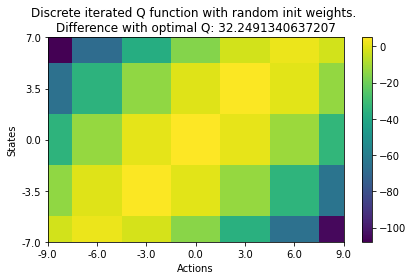

In [37]:
full_batch = {
    "reward": replay_buffer.rewards,
    "next_state": replay_buffer.next_states,
}
discrete_iterated_q_from_random = pbo_function.compute_target(full_batch, random_init_q_weights.reshape(1, -1)).reshape((n_discrete_states, n_discrete_actions))
discrete_iterated_q_from_random_pd = pd.DataFrame(discrete_iterated_q_from_random, index=discrete_states, columns=discrete_actions)

q_funcions_visualization_mesh.set_values(discrete_iterated_q_from_random)
q_funcions_visualization_mesh.show(
    f"Discrete iterated Q function with random init weights. \nDifference with optimal Q: {np.linalg.norm(discrete_iterated_q_from_random - optimal_q, ord=1)}"
)

### Training

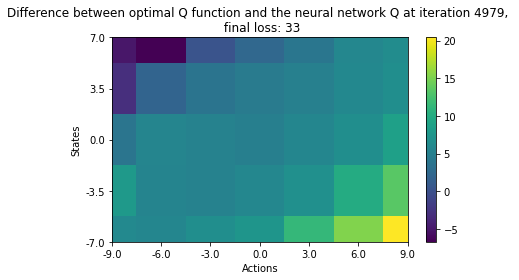

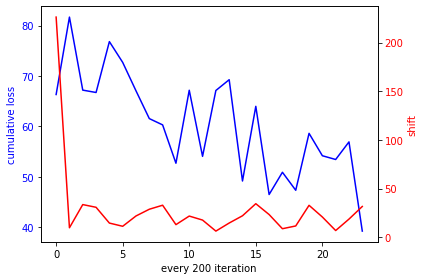

In [43]:
import optax

optimizer = optax.sgd(learning_rate=learning_rate_pbo)
optimizer_state = optimizer.init(pbo_function.params)

# For visualization
previous_discrete_q_network = q_function.get_discrete_q(random_init_q_params, discrete_states, discrete_actions)
cumulative_losses = []
shifts = []

iteration = 0
cumulative_loss = float("inf")

while cumulative_loss > np.prod(discrete_iterated_q_from_random_pd.shape) and iteration < max_iterations:
    cumulative_loss = 0
    
    data_loader_pbo.shuffle()
    for batch in data_loader_pbo:
        target = jnp.diag(discrete_iterated_q_from_random_pd.loc[batch["state"].flatten(), batch["action"].flatten()].values).reshape(-1, 1)

        loss, grad_loss = pbo_function.loss_and_grad_loss(pbo_function.params, batch, random_init_q_weights.reshape(1, -1), target)
        updates, optimizer_state = optimizer.update(
            grad_loss, optimizer_state
        )
        pbo_function.params = optax.apply_updates(pbo_function.params, updates)

        cumulative_loss += loss

    iteration += 1

    # Plot Q network
    if iteration % plot_freq == 0:
        iterated_q_weights = pbo_function.network.apply(pbo_function.params, random_init_q_weights)
        iterated_q_params = q_function.convert_to_params(iterated_q_weights)
        discrete_q_network = q_function.get_discrete_q(iterated_q_params, discrete_states, discrete_actions)
        shift = np.linalg.norm(discrete_q_network - previous_discrete_q_network)

        q_funcions_visualization_mesh.set_values(discrete_q_network)
        q_funcions_visualization_mesh.show(f"Discrete Q function at iteration {iteration}, \nloss: {int(cumulative_loss)}, shift: {np.around(shift, 2)}")
        
        cumulative_losses.append(cumulative_loss)
        shifts.append(shift)
        previous_discrete_q_network = discrete_q_network

iterated_q_weights = pbo_function.network.apply(pbo_function.params, random_init_q_weights)
iterated_q_params = q_function.convert_to_params(iterated_q_weights)
discrete_q_network = q_function.get_discrete_q(iterated_q_params, discrete_states, discrete_actions)
q_funcions_visualization_mesh.set_values(discrete_q_network - optimal_q)
q_funcions_visualization_mesh.show(f"Difference between optimal Q function and the neural network Q at iteration {iteration}, \n final loss: {int(cumulative_loss)}")

# Plot the shifts and the loss
fig, ax1 = plt.subplots()

ax1.set_xlabel(f"every {plot_freq} iteration")
ax1.set_ylabel("cumulative loss", color="blue")
ax1.plot(np.arange(len(cumulative_losses)), cumulative_losses, color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("shift", color="red")
ax2.plot(np.arange(len(shifts)), shifts, color="red")
ax2.tick_params(axis="y", labelcolor="red")

fig.tight_layout()
plt.show()

## Train PBO on one iteration over two random init weight

### Define the two random init weights and its iterated versions

In [49]:
random_init_q_weights_1 = q_function.get_random_init_weights()
random_init_q_params_1 = q_function.convert_to_params(random_init_q_weights_1)
random_init_q_weights_2 = q_function.get_random_init_weights()
random_init_q_params_2 = q_function.convert_to_params(random_init_q_weights_2)

random_init_q_weights = jnp.vstack((random_init_q_weights_1, random_init_q_weights_2))

### Training

In [ ]:
import optax

optimizer = optax.sgd(learning_rate=learning_rate_pbo)
optimizer_state = optimizer.init(pbo_function.params)

# For visualization
previous_discrete_q_network = q_function.get_discrete_q(random_init_q_params[0], discrete_states, discrete_actions)
cumulative_losses = []
shifts = []

iteration = 0
cumulative_loss = float("inf")

while cumulative_loss > np.prod(discrete_iterated_q_from_random_pd.shape) and iteration < max_iterations:
    cumulative_loss = 0
    
    data_loader_pbo.shuffle()
    for batch in data_loader_pbo:
        target = jnp.diag(discrete_iterated_q_from_random_pd.loc[batch["state"].flatten(), batch["action"].flatten()].values).reshape(-1, 1)

        loss, grad_loss = pbo_function.loss_and_grad_loss(pbo_function.params, batch, random_init_q_weights.reshape(1, -1), target)
        updates, optimizer_state = optimizer.update(
            grad_loss, optimizer_state
        )
        pbo_function.params = optax.apply_updates(pbo_function.params, updates)

        cumulative_loss += loss

    iteration += 1

    # Plot Q network
    if iteration % plot_freq == 0:
        iterated_q_weights = pbo_function.network.apply(pbo_function.params, random_init_q_weights)
        iterated_q_params = q_function.convert_to_params(iterated_q_weights)
        discrete_q_network = q_function.get_discrete_q(iterated_q_params, discrete_states, discrete_actions)
        shift = np.linalg.norm(discrete_q_network - previous_discrete_q_network)

        q_funcions_visualization_mesh.set_values(discrete_q_network)
        q_funcions_visualization_mesh.show(f"Discrete Q function at iteration {iteration}, \nloss: {int(cumulative_loss)}, shift: {np.around(shift, 2)}")
        
        cumulative_losses.append(cumulative_loss)
        shifts.append(shift)
        previous_discrete_q_network = discrete_q_network

iterated_q_weights = pbo_function.network.apply(pbo_function.params, random_init_q_weights)
iterated_q_params = q_function.convert_to_params(iterated_q_weights)
discrete_q_network = q_function.get_discrete_q(iterated_q_params, discrete_states, discrete_actions)
q_funcions_visualization_mesh.set_values(discrete_q_network - optimal_q)
q_funcions_visualization_mesh.show(f"Difference between optimal Q function and the neural network Q at iteration {iteration}, \n final loss: {int(cumulative_loss)}")

# Plot the shifts and the loss
fig, ax1 = plt.subplots()

ax1.set_xlabel(f"every {plot_freq} iteration")
ax1.set_ylabel("cumulative loss", color="blue")
ax1.plot(np.arange(len(cumulative_losses)), cumulative_losses, color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("shift", color="red")
ax2.plot(np.arange(len(shifts)), shifts, color="red")
ax2.tick_params(axis="y", labelcolor="red")

fig.tight_layout()
plt.show()

## Train PBO

In [ ]:
import optax

optimizer = optax.sgd(learning_rate=learning_rate_pbo)
optimizer_state = optimizer.init(pbo_function.params)

for iteration in range(n_iterations):
    random_weights = q_function.get_random_init_weights()
    data_loader_pbo.shuffle()

    for batch in data_loader_pbo:
        target = pbo_function.compute_target(batch, random_weights)
        loss, grad_loss = pbo_function.loss_and_grad_loss(pbo_function.params, batch, random_weights, target)
        print(grad_loss)
        updates, optimizer_state = optimizer.update(
            grad_loss, optimizer_state
        )
        pbo_function.params = optax.apply_updates(pbo_function.params, updates)

    # Plot the fixed point Q network
    fixed_point_params = q_function.convert_to_params(pbo_function.get_fixed_point())
    discrete_q_network = q_function.get_discrete_q(fixed_point_params, discrete_states, discrete_actions)
    
    # q_funcions_visualization_mesh.set_values(discrete_q_network)
    # q_funcions_visualization_mesh.show(f"Discrete Q function at iteration {iteration}")

{'LinearNet/linear': {'b': DeviceArray([ 3.39036484e+01,  2.81922054e+01,  1.47147143e+00,
             -2.68614159e+01, -1.66711664e+00, -3.52910042e+01,
             -3.49088326e+01, -2.75219488e+00, -6.75106514e-03,
              0.00000000e+00, -1.56897278e+01,  2.22070770e+01,
              1.61499615e+01, -8.61220264e+00,  4.56067429e+01,
             -2.93591576e+01, -2.30471268e+01,  4.62337106e-01,
              9.27585030e+00, -2.24954629e+00,  7.57211637e+00,
             -1.27611132e+01, -2.97378654e+01,  1.46416159e+01,
              8.98709583e+00,  8.09351981e-01,  1.24819775e+01,
              1.11016703e+01,  3.48144007e+00,  0.00000000e+00,
              1.99725418e+01,  1.85912056e+01, -4.18541336e+00,
              1.33181667e+00, -1.46266818e+00,  2.00943108e+01,
              2.85086346e+01, -6.61860847e+00, -1.60667381e+01,
              8.46063995e+00,  3.86169052e+00, -1.92903984e+00,
              8.36116409e+00, -2.18369694e+01, -8.52026761e-01,
             